# Proyecto Desarrollo Soluciones
### 1. Descripción del Proyecto
Este proyecto tiene como objetivo desarrollar un sistema de clasificación de imágenes de animales utilizando técnicas de aprendizaje automático. El sistema está diseñado para identificar y clasificar imágenes de cuatro especies de animales: búfalos, elefantes, rinocerontes y cebras.

### 2. Configuración inicial
Se definen las dependencias necesarias y se configuran las semillas para asegurar la reproducibilidad de los resultados.

In [1]:
import os
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
import imagehash
from collections import defaultdict

In [2]:
SEED = 99
DATA_DIR = '../data/dataset'

### 2. Análisis Exploratorio de Datos
El análisis exploratorio de datos (EDA) se realiza para comprender mejor las características de las imágenes y las distribuciones de las clases.

#### A. Carga de Datos y Balanceo de Clases
Las imágenes se cargan desde el directorio `data/dataset`, que contiene subdirectorios para cada clase de animal.

In [3]:
for folder in os.listdir(DATA_DIR):
    folder_path = os.path.join(DATA_DIR, folder)
    if not os.path.isdir(folder_path) or folder.startswith('.'):
        continue 
    
    num_images = len(os.listdir(os.path.join(DATA_DIR, folder)))
    print(f'{folder}: {num_images} imágenes')


Buffalo: 1000 imágenes
Elephant: 1000 imágenes
Rhino: 1000 imágenes
Zebra: 1000 imágenes


Se puede evidenciar que cada clase cuenta con 1000 imágenes. Por lo tanto, el dataset está balanceado.

### B. Visualización de imágenes
A continuación, se muestran algunas imágenes de cada clase para tener una idea visual del dataset.

In [4]:
def show_class_samples_grid(folder_path, n=5):
    """
    Muestra una cuadrícula de imágenes con una columna por clase 
    y n filas de ejemplos por clase.
    
    Parámetros:
    - folder_path: str, ruta al directorio principal con subcarpetas por clase.
    - n: int, número de imágenes por clase a mostrar.
    """
    
    class_names = sorted(os.listdir(folder_path))
    
    num_classes = len(class_names)
    plt.figure(figsize=(num_classes*3, n*3))  # más ancho si hay muchas clases
    
    for col, class_name in enumerate(class_names):
        class_path = os.path.join(folder_path, class_name)
        images = os.listdir(class_path)
        
        random.seed(SEED)
        sample_images = random.sample(images, min(n, len(images)))
        
        for row, img_file in enumerate(sample_images):
            img_path = os.path.join(class_path, img_file)
            img = mpimg.imread(img_path)
            
            plt.subplot(n, num_classes, row*num_classes + col + 1)
            plt.imshow(img)
            
            if row == 0:  # título solo en la primera fila de cada columna
                plt.title(class_name, fontsize=14)
            
            plt.axis("off")
    
    plt.tight_layout()
    plt.show()

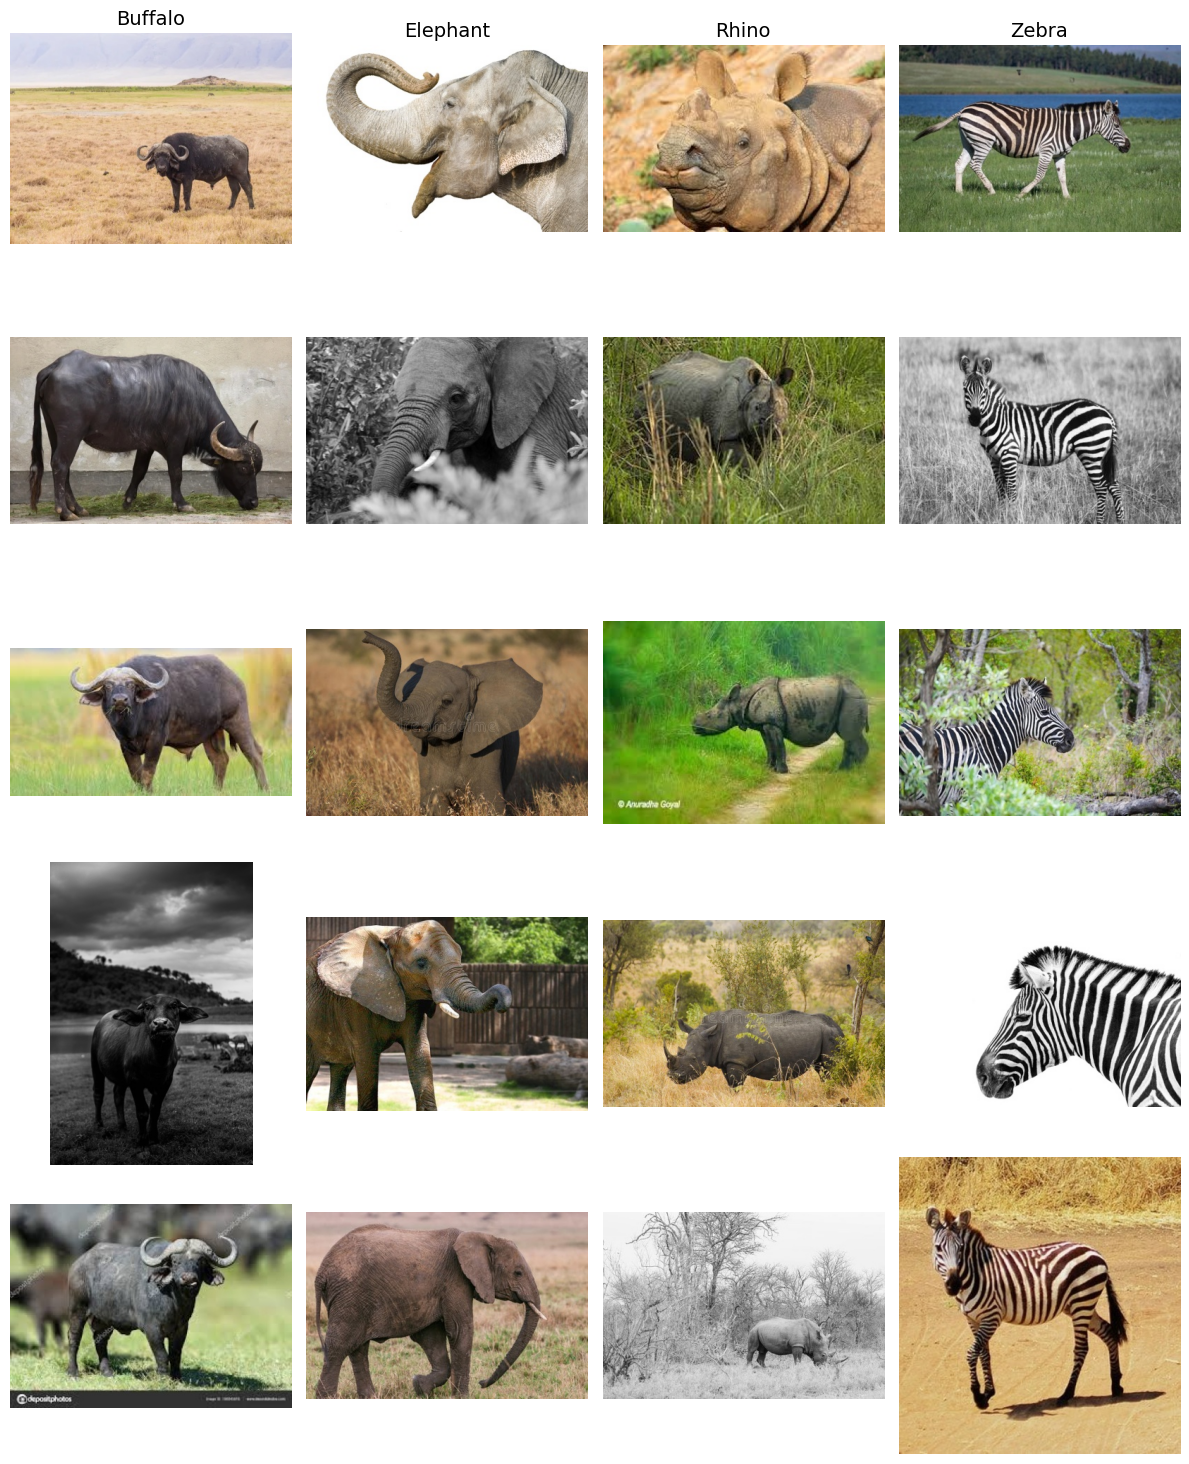

In [7]:
show_class_samples_grid(DATA_DIR)

**Conclusiones de las imágenes**

- Diversidad intra-clase: Dentro de una misma especie (ej. elefantes, búfalos, cebras) hay variaciones notables en **ángulos, fondos, colores y poses**.  Esto es positivo porque el modelo podrá **aprender a generalizar mejor**.  

- Escala y encuadre: En algunas imágenes los animales aparecen **completos**, y en otras solo de forma **parcial** (ej. la cabeza del rinoceronte).  Esto puede dificultar al modelo si necesita distinguir **rasgos globales vs. locales**.  

- Resolución: Las imágenes tienen **diferentes resoluciones**.  Esto puede afectar el rendimiento del modelo si no se normaliza bien la entrada (ej. redimensionar todas a un tamaño fijo).

-  Blanco y negro vs. color: Algunas imágenes están en blanco y negro, lo cual puede ser un reto si no se normaliza bien la entrada.  

### C. Dimensiones y formatos de imágenes
- **Resolución de imágenes**: analizar las dimensiones (ancho × alto) para identificar si existe variabilidad significativa en tamaños.  
- **Formatos de archivo**: revisar la proporción de extensiones (ej. `.jpg`, `.png`, etc.) en el dataset.  

Este análisis es útil para decidir si es necesario **redimensionar** todas las imágenes a un mismo tamaño y **homogeneizar formatos** antes del entrenamiento.


In [8]:
def get_image_properties(folder_path):
    """
    Recorre el dataset y devuelve las resoluciones y formatos de las imágenes.
    
    Retorna:
    - res_counter: Counter con resoluciones (ancho x alto).
    - fmt_counter: Counter con formatos (.jpg, .png, etc.).
    """
    class_names = sorted(os.listdir(folder_path))
    
    resolutions = []
    formats = []

    for class_name in class_names:
        class_path = os.path.join(folder_path, class_name)
        images = os.listdir(class_path)
        
        for img_file in images:
            img_path = os.path.join(class_path, img_file)
            try:
                img = mpimg.imread(img_path)
                resolutions.append(f"{img.shape[1]}x{img.shape[0]}")
                formats.append(os.path.splitext(img_file)[-1].lower())
            except Exception as e:
                print(f"Error: No se pudo leer {img_path}: {e}")
    
    return Counter(resolutions), Counter(formats)


def plot_resolutions(res_counter, top_n=10):
    """
    Muestra un gráfico de barras con las resoluciones más comunes.
    """
    top_res = res_counter.most_common(top_n)
    labels, counts = zip(*top_res)
    
    plt.figure(figsize=(10,5))
    plt.bar(labels, counts)
    plt.xticks(rotation=45, ha="right")
    plt.title("Resoluciones más comunes")
    plt.xlabel("Resolución (ancho x alto)")
    plt.ylabel("Número de imágenes")
    plt.show()


def plot_formats(fmt_counter):
    """
    Muestra un gráfico de barras con la proporción de formatos de imagen.
    """
    labels, counts = zip(*fmt_counter.items())
    
    plt.figure(figsize=(6,4))
    plt.bar(labels, counts, color="orange")
    plt.title("Proporción de formatos de imagen")
    plt.xlabel("Formato")
    plt.ylabel("Número de imágenes")
    plt.show()
    
def count_orientations(res_counter):
    """
    Recibe un Counter de resoluciones en formato "ancho x alto"
    y devuelve el conteo de imágenes horizontales y verticales.
    """
    vertical = 0
    horizontal = 0

    for res, count in res_counter.items():
        width, height = map(int, res.split("x"))
        if height > width:
            vertical += count
        else:
            horizontal += count
    
    total = vertical + horizontal
    return {
        "horizontal": horizontal,
        "vertical": vertical,
        "vertical_ratio": vertical / total if total > 0 else 0
    }


In [9]:
res_counter, fmt_counter = get_image_properties(DATA_DIR)

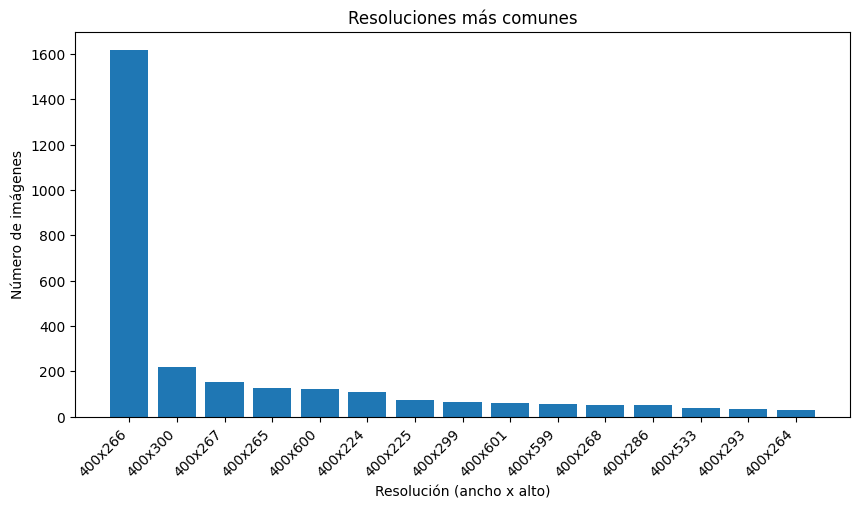

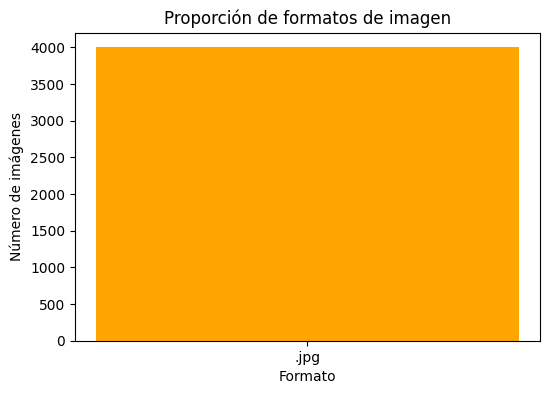

In [10]:
plot_resolutions(res_counter, top_n=15)
plot_formats(fmt_counter)

In [11]:
print(f"Se han encontrado {len(res_counter)} resoluciones únicas.")

Se han encontrado 313 resoluciones únicas.


In [12]:
orientations = count_orientations(res_counter)
print(f"Imágenes horizontales: {orientations['horizontal']}")
print(f"Imágenes verticales: {orientations['vertical']}. Siendo {orientations['vertical_ratio']:.2%} del total.")

Imágenes horizontales: 3530
Imágenes verticales: 470. Siendo 11.75% del total.


**Conclusiones**
- Se encontraron **313 resoluciones únicas** en el conjunto de imágenes.  
- A pesar de esta diversidad, la mayoría de las resoluciones mantienen una **relación de aspecto estable**.  
- Los grupos principales de relaciones de aspecto son:  
  - **≈ 3:2 (1.5):** 400×266 (mayoría considerable con 1600 imágenes), 400×267, 400×265, 400×268, 400×264  
  - **≈ 4:3 (1.33):** 400×300, 400×299, 400×293, 400×286  
  - **≈ 16:9 (1.78):** 400×224, 400×225  
- También aparecen resoluciones menos comunes con orientaciones **verticales o más cuadradas**:  
  - Ejemplo: 400×600, 400×601, 400×599 (≈ 0.67)  
  - Ejemplo: 400×533 (≈ 0.75)

- Aunque existen muchas resoluciones distintas, las imágenes se concentran mayoritariamente en proporciones **3:2 y 4:3**, lo que indica una **consistencia visual estable** en el dataset.  
Las resoluciones atípicas (verticales o muy panorámicas) son minoritarias, siendo 470 imágenes equivalentes a un 11.75% del total.

- Todas las imágenes están en formato **jpg**.

**Implicaciones para el preprocesamiento**

- Como la mayoría de imágenes tienen relaciones de aspecto **3:2 y 4:3**, conviene escoger una resolución estándar cercana (ejemplo: 256×256 o 224×224) y redimensionar manteniendo proporciones con *padding* para no deformar las imágenes.  

- Dado que el dataset es bastante homogéneo en sus proporciones, es importante conservar la relación de aspecto durante el escalado. Esto asegura que las imágenes no se distorsionen y la consistencia visual se mantenga.  

- Manejo de casos atípicos (verticales o panorámicos): Se pueden recortar o usar *letterboxing* (bordes negros/blancos) para integrarlas al formato estándar. Si bien son la minoría, representan un porcentaje mayor al 10% de los datos, por lo cual, es mejor no descartarlos. 

- Usar un tamaño final único (ejemplo: `224×224` para modelos preentrenados como ResNet, ViT, EfficientNet) con *padding* asegura que todo el dataset sea uniforme y compatible con arquitecturas de deep learning.

### D. Análisis de calidad de imágenes
- **Integridad de archivos:** Se valida que todas las imágenes pudieran abrirse correctamente. No se encontraron archivos corruptos.  
- **Duplicados o casi idénticos:** Aplicar un chequeo de duplicados para evitar redundancias que puedan sesgar el entrenamiento. 

In [13]:
def find_duplicate_images(data_dir, hash_size=8, threshold=5):
    """
    Detecta imágenes duplicadas o casi idénticas en un dataset usando perceptual hashing.

    Parámetros:
    - data_dir: carpeta raíz que contiene las clases.
    - hash_size: tamaño del hash perceptual (mayor = más precisión).
    - threshold: distancia máxima de Hamming para considerar dos imágenes como duplicadas.

    Retorna:
    - duplicates: diccionario con imágenes agrupadas por duplicados.
    """
    hashes = {}
    duplicates = defaultdict(list)

    for class_folder in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_folder)
        if not os.path.isdir(class_path):
            continue
        
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                with Image.open(img_path) as img:
                    # calculamos perceptual hash
                    phash = imagehash.phash(img, hash_size=hash_size)
                    
                    # buscamos duplicados
                    found = False
                    for stored_path, stored_hash in hashes.items():
                        if phash - stored_hash <= threshold:
                            duplicates[stored_path].append(img_path)
                            found = True
                            break
                    if not found:
                        hashes[img_path] = phash
            except Exception as e:
                print(f"Error leyendo {img_path}: {e}")
    
    return duplicates


def show_duplicate_samples(duplicates, num_groups=5):
    """
    Muestra una muestra de grupos de imágenes duplicadas o casi idénticas.
    """
    groups = list(duplicates.items())
    random.seed(SEED)
    sampled_groups = random.sample(groups, min(num_groups, len(groups)))
    
    for i, (original, dups) in enumerate(sampled_groups):
        plt.figure(figsize=(12, 4))
        images_to_show = [original] + dups
        for j, img_path in enumerate(images_to_show):
            try:
                img = Image.open(img_path)
                plt.subplot(1, len(images_to_show), j+1)
                plt.imshow(img)
                plt.title("Original" if j == 0 else f"Duplicate {j}")
                plt.axis("off")
            except:
                continue
        plt.suptitle(f"Grupo {i+1}", fontsize=14)
        plt.show()


In [14]:
# Buscar imágenes corruptas
corrupt_files = []

for class_folder in os.listdir(DATA_DIR):
    class_path = os.path.join(DATA_DIR, class_folder)
    
    # Skip hidden folders or non-directories
    if not os.path.isdir(class_path) or class_folder.startswith('.'):
        continue
    
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        try:
            with Image.open(img_path) as img:
                img.verify()  # Check integrity
        except (IOError, SyntaxError):
            corrupt_files.append(img_path)

print(f'{len(corrupt_files)} imágenes corruptas encontradas')


0 imágenes corruptas encontradas


In [15]:
duplicates = find_duplicate_images(DATA_DIR)
print(f"Se encontraron {len(duplicates)} grupos de imágenes duplicadas o casi idénticas")

Se encontraron 236 grupos de imágenes duplicadas o casi idénticas


In [16]:
duplicates_list = list(duplicates.items())
random.sample(duplicates_list,5)   

[('../data/dataset\\Buffalo\\Buffalo_858.jpg',
  ['../data/dataset\\Buffalo\\Buffalo_860.jpg']),
 ('../data/dataset\\Buffalo\\Buffalo_917.jpg',
  ['../data/dataset\\Buffalo\\Buffalo_936.jpg']),
 ('../data/dataset\\Buffalo\\Buffalo_686.jpg',
  ['../data/dataset\\Buffalo\\Buffalo_688.jpg']),
 ('../data/dataset\\Zebra\\Zebra_670.jpg',
  ['../data/dataset\\Zebra\\Zebra_736.jpg']),
 ('../data/dataset\\Buffalo\\Buffalo_217.jpg',
  ['../data/dataset\\Buffalo\\Buffalo_608.jpg'])]

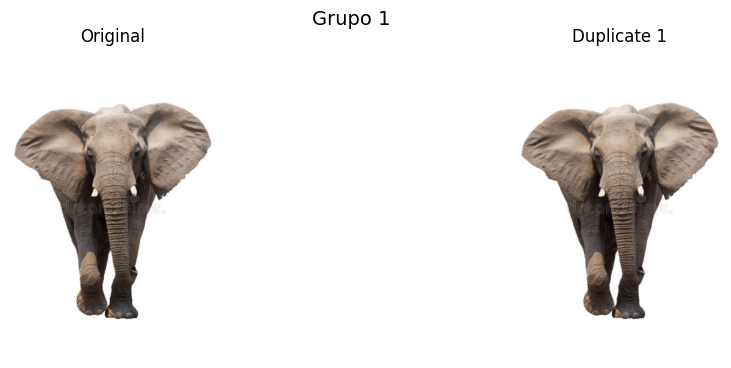

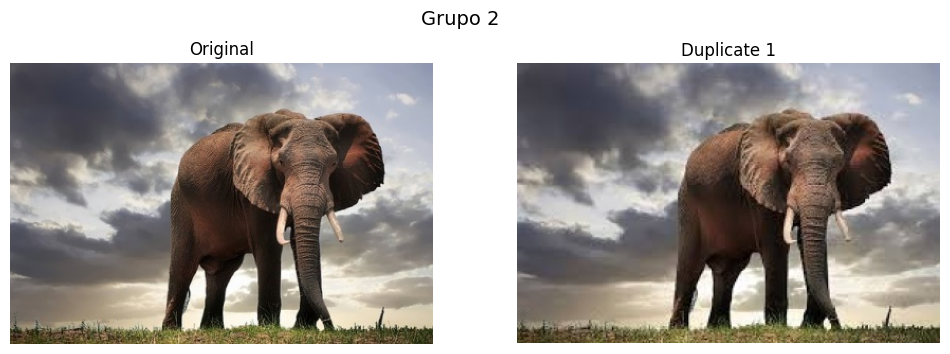

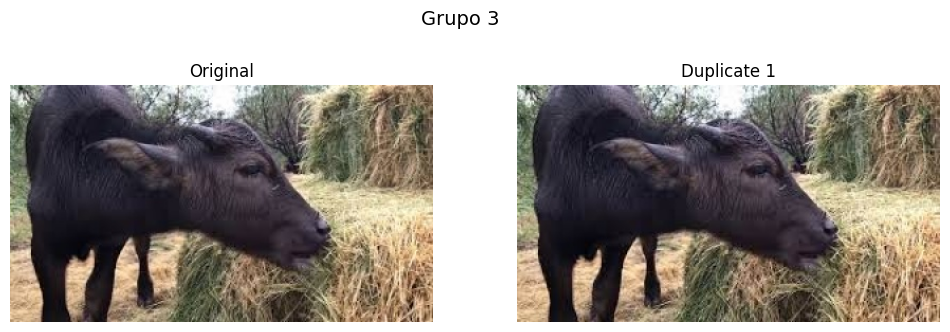

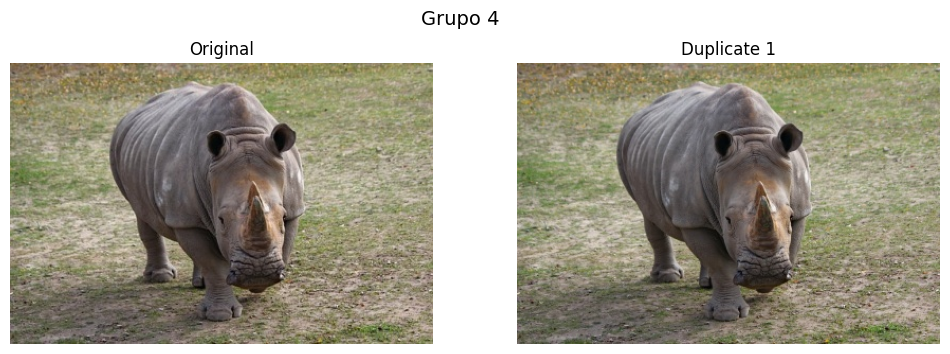

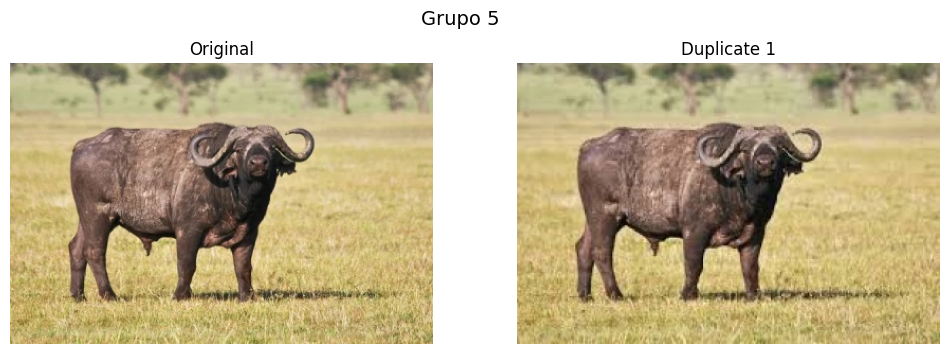

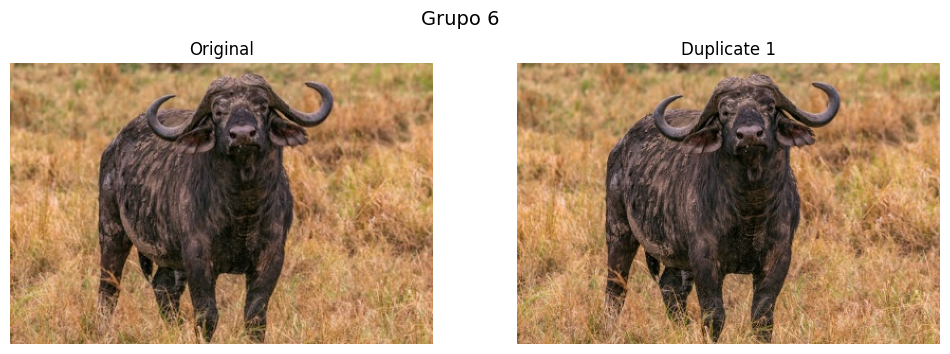

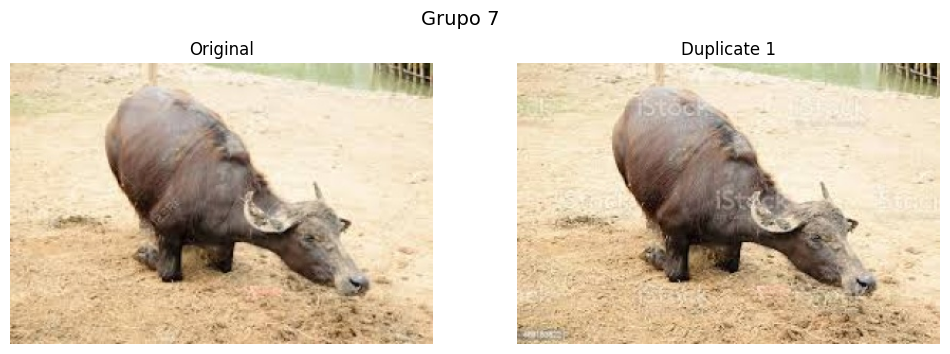

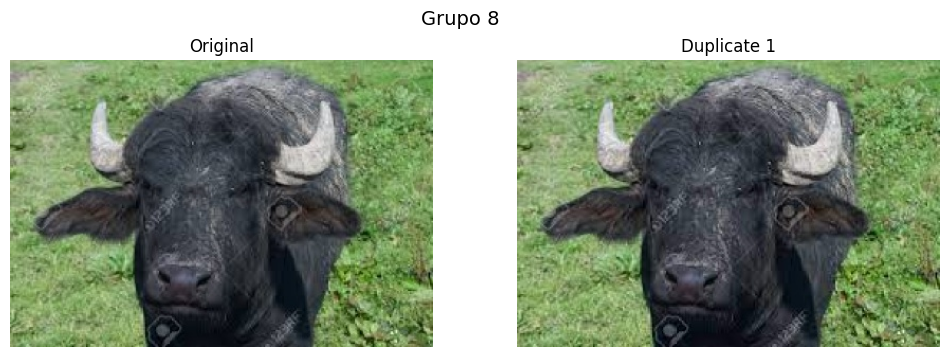

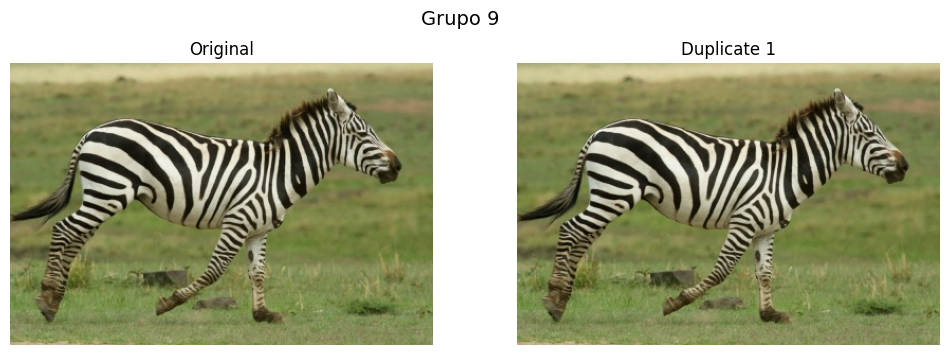

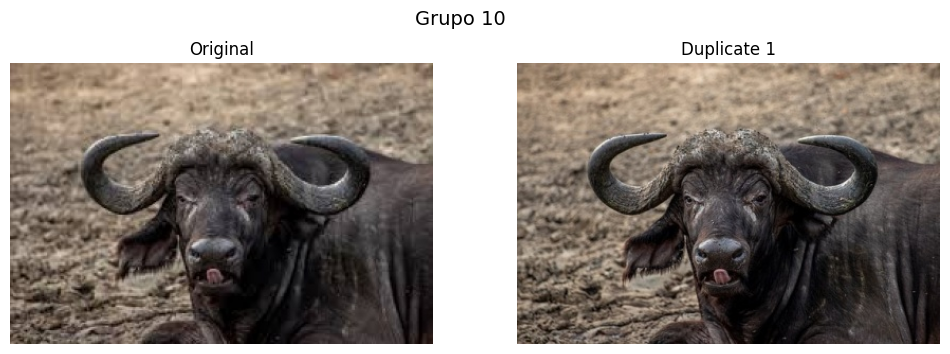

In [17]:
show_duplicate_samples(duplicates, num_groups=10)

TODO: Redactar conclusiones de la sección

### E. Distribución de colores